importing the required libraries

In [2]:
from collections import Counter, OrderedDict

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm

converting all images to rgb format

In [3]:
class ToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

a basic Compose of transforms to apply on images

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ToRGB(),
    transforms.ToTensor()
])

In [5]:
# paths to the data directories
data_dir = Path('..', 'data')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'

reading in the data using ImageFolder method from pytorch datasets and creating a Dataloader object 

In [6]:
train_dataset = datasets.ImageFolder(train_dir, transform = transform)
len(train_dataset)

classes = train_dataset.classes


In [7]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size = batch_size)

displaying a random picture from the data loader

Text(0.5, 1.0, 'anger')

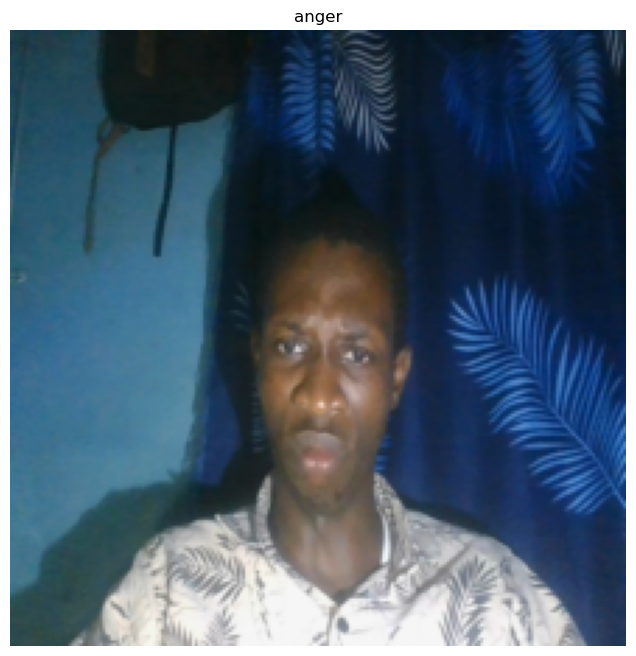

In [8]:
i = 5
ex = next(iter(train_loader))[0][i]
lbl = next(iter(train_loader))[1][i].item()
im = ex.permute(1, 2, 0).numpy()  # Shape: (220, 220, 3)

plt.figure(figsize=(10, 8)) 
plt.imshow(im)
plt.axis('off')
plt.title(classes[lbl])

adding a normalizing transform to the transform Compose to maintain the right range of values

In [9]:
def get_mean_std(loader):
    count, batchsum, squaredbatchsum = 0, 0, 0
    for data, _ in tqdm(loader):
        batchsum += torch.mean(data, dim = [0, 2, 3])
        squaredbatchsum += torch.mean(data **2, dim =  [0, 2, 3])
        count += 1
    
    mean = batchsum / count
    std = (squaredbatchsum / count - mean**2) ** 0.5
    
    return mean, std
mean, std = get_mean_std(train_loader)
print(f"mean: {mean}")
print(f"std: {std}")

  0%|          | 0/4 [00:00<?, ?it/s]

mean: tensor([0.2625, 0.3384, 0.4102])
std: tensor([0.2647, 0.2349, 0.2244])


In [10]:
norm_transform = transforms.Compose([
    transforms.Resize((220, 220)),
    ToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

In [11]:
train_norm_dataset = datasets.ImageFolder(train_dir, transform = norm_transform)

splitting into training and validating data

In [12]:
g = torch.Generator()
g.manual_seed(45)

train_data, val_data = random_split(train_norm_dataset, lengths = (0.8, 0.2), generator = g)
print(f"train length: {len(train_data)}")
print(f"test length: {len(val_data)}")

train length: 32
test length: 8


checking the count of the classes represented in each of training and validating data

In [13]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    while isinstance(dataset, torch.utils.data.Subset):
        dataset = dataset.dataset
    class_to_index = dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

  0%|          | 0/32 [00:00<?, ?it/s]

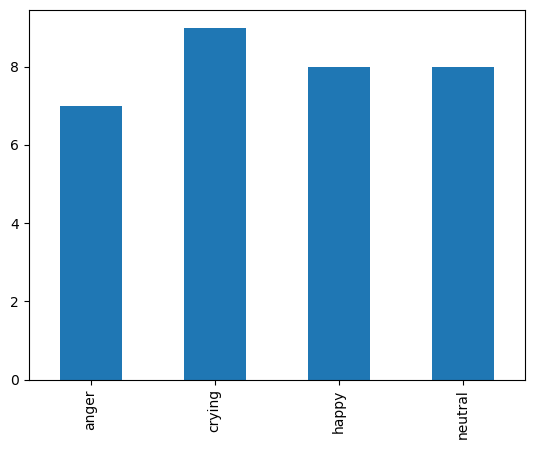

  0%|          | 0/8 [00:00<?, ?it/s]

<Axes: >

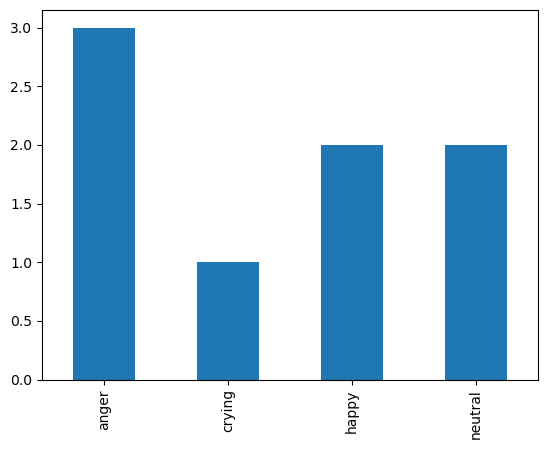

In [14]:
class_counts(train_data).plot(kind = 'bar')
plt.show()
class_counts(val_data).plot(kind = 'bar')

In [15]:
batch_size = 4
train_loader = DataLoader(train_data, batch_size = batch_size)
val_loader = DataLoader(val_data, batch_size = batch_size)

defining the model architecture

In [16]:
model = torch.nn.Sequential(OrderedDict([
    ("conv1", torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)),
    ("pool1", torch.nn.MaxPool2d(kernel_size=(2, 2))),
    ("relu1", torch.nn.ReLU()),
    ("conv2", torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3))),
    ("pool2", torch.nn.MaxPool2d(kernel_size=(2, 2))),
    ("relu2", torch.nn.ReLU()),
    ("conv3", torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3))),
    ("pool3", torch.nn.MaxPool2d(kernel_size=(2, 2))),
    ("relu3", torch.nn.ReLU()),
    ("flatten", torch.nn.Flatten()),
    ("fc", torch.nn.Linear(in_features=16 * 26 * 26, out_features=4))
]))


setting the loss function and the optimizer

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 10

training the model

In [18]:
losses = []
for epoch in range(epochs):
    for data, labels in tqdm(train_loader):
        optim.zero_grad()

        output = model(data)
        loss = loss_fn(output, labels)

        loss.backward()
        optim.step()
        losses.append(loss.item())


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

visualizing the training loss 

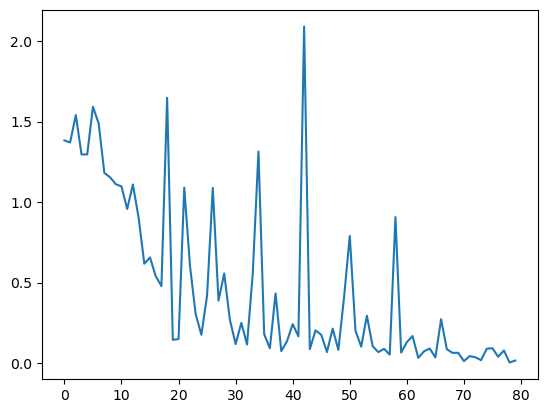

In [19]:
plt.plot(losses)

evaluating the model on the validation data

In [20]:
val_losses = []
val_accuracy = []
with torch.no_grad():
    count = 0
    for images, labels in tqdm(val_loader):
        output = model(images)
        count += 1
        loss = loss_fn(output, labels)
        val_losses.append(loss.item())
        print(count)

        correct = torch.eq(torch.argmax(output, dim = 1), labels)
        total_correct = torch.sum(correct).item()
        accuracy = total_correct / len(val_loader.dataset)
        val_accuracy.append(accuracy)

  0%|          | 0/2 [00:00<?, ?it/s]

1
2


In [21]:
# plt.plot(val_losses)
val_losses

[0.2273036688566208, 0.4986809492111206]

In [22]:
accuracy

0.375